In this Script, we just want to compute the MMDs with different techniques and, since these computations are computationally intense, save the vectors.
In another script, we can just load the MMDs and pixels to work with them.

In [2]:
# load some packages
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd

# load the catalogue
catalogue1000 = np.load('catalogue_1000sqd.npy')
catalogue = np.load('catalogue.npy')

In [3]:
nside = 64 # HEALPix nside parameter

cl_kappa_225 = np.loadtxt('cl_kappa_mean_225.txt')[:,1] # load power spectrum
cl_kappa_225 = np.concatenate((np.zeros(2), cl_kappa_225)) # add zeros for monopole and dipole
kappamap_225 = hp.synfast(cl_kappa_225, nside)  # generate kappa map from power spectrum
print("Cl_kappa225 shape:", cl_kappa_225.shape, "   kappamap225 shape:", kappamap_225.shape )

pixscale = 0.263
sizes_in_arcsec1000 = catalogue1000['r50'] * pixscale   #arcsec

# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix1000= hp.ang2pix(nside, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
galaxy_pix1000_unique, galaxy_pix1000_counts = np.unique(galaxy_pix1000, return_counts=True)
n_pixels = hp.nside2npix(nside)

intrinsic_size1000 = sizes_in_arcsec1000
observed_size1000 = sizes_in_arcsec1000 * (1.0 + kappamap_225[galaxy_pix1000])

size_mask1000 = (intrinsic_size1000 < 5.0) #arcsec


Cl_kappa225 shape: (10000,)    kappamap225 shape: (49152,)


In [4]:
# Same for the smaller catalogue
cl_kappa = np.loadtxt('cl_kappa.txt')
cl_kappa = np.concatenate((np.zeros(2), cl_kappa)) # add zeros for monopole and dipole
kappamap = hp.synfast(cl_kappa, nside) # generate a convergence map

pixscale = 0.263
sizes_in_arcsec = catalogue['r50'] * pixscale   # arcsec
galaxy_pix = hp.ang2pix(nside, np.deg2rad(catalogue['ra']), np.deg2rad(catalogue['dec']))  
galaxy_pix_unique, galaxy_pix_counts = np.unique(galaxy_pix, return_counts=True)

intrinsic_size = sizes_in_arcsec
observed_size = sizes_in_arcsec * (1.0 + kappamap[galaxy_pix])
size_mask = (intrinsic_size < 5.0) #arcsec

Functions to compute the MMD with different Kernels


In [5]:
# NEW IMPLEMENTATION OF MMD FOR DIFFERENT KERNELS ---------------------------------
def compute_mmd(X, Y, kernel):
    """
    Compute Maximum Mean Discrepancy (MMD) between samples X and Y using a provided kernel.
    
    Parameters:
        X: array-like, shape (n_samples_X, n_features)
        Y: array-like, shape (n_samples_Y, n_features)
        kernel: callable, must support signature kernel(X, Y), returns kernel matrix
        
    Returns:
        mmd: float, MMD value
    """

    X = np.asarray(X)
    Y = np.asarray(Y)
    m = X.shape[0]
    n = Y.shape[0]
    
    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)
    
    # Remove diagonal for unbiased estimator
    # np.fill_diagonal(K_XX, 0)
    # np.fill_diagonal(K_YY, 0)
    
    mmd2 = (K_XX.sum() / (m * (m - 1))) \
        + (K_YY.sum() / (n * (n - 1))) \
        - (2 * K_XY.sum() / (m * n))
    
    return mmd2

def compute_mmd_subsample(X, Y, kernel, size_X=1000, size_Y=1000, n_iter=10, random_state=None):
    """
    Compute MMD between large X and Y by random subsampling.
    Parameters:
        X: array-like (N_X, features), large dataset
        Y: array-like (N_Y, features), large dataset
        kernel: callable kernel (scikit-learn compatible)
        size_X: int, subsample size from X
        size_Y: int, subsample size from Y
        n_iter: int, number of repetitions
        random_state: int or None, reproducibility
    Returns:
        avg_mmd: float, average MMD over n_iter subsamples
        mmd_values: list of individual MMD values
    """
    rng = np.random.default_rng(random_state)
    mmd_values = []
    for i in range(n_iter):
        Xs = rng.choice(X, size_X, replace=False)
        Ys = rng.choice(Y, size_Y, replace=False)
        mmd = compute_mmd(Xs, Ys, kernel)
        mmd_values.append(mmd)
    return np.mean(mmd_values)


In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel

mmd2_lensed_MC1000 = []
Y_lensed1000 = observed_size1000[size_mask1000].reshape(-1, 1)
for p in galaxy_pix1000_unique:
    mask = (galaxy_pix1000 == p) 
    if mask.sum() > 20000:
        X_lensed1000 = observed_size1000[mask & size_mask1000].reshape(-1, 1)
        mmd2_lensed_MC1000.append(compute_mmd_subsample(X_lensed1000, Y_lensed1000, rbf_kernel, 20000,20000,10,42))

mmd2_lensed_MC1000 = np.array(mmd2_lensed_MC1000)


## Random Fourier Features
We will try to implement RFF for the MMD using an RBF kernel. This method approximates the MMD and uses no pairwise matrices, tiny memory and includes all galaxies instead of sampling only 20'000.

In [6]:
# Core RFF Utilities
def make_rff_params(d, n_features=1024, sigma=1.0, rng=None):
    """
    Create RFF parameters for an RBF(σ) kernel.
    RBF: k(x,y) = exp(-||x - y||^2 / (2 σ^2))

    Returns:
      W: (d, n_features) with entries ~ N(0, 1/σ^2)
      b: (n_features,) with entries ~ Uniform[0, 2π]
      scale: sqrt(2/n_features)
    """
    rng = np.random.default_rng(rng)
    W = rng.normal(loc=0.0, scale=1.0/sigma, size=(d, n_features)).astype(np.float32)
    b = rng.uniform(0.0, 2.0*np.pi, size=(n_features,)).astype(np.float32)
    scale = np.sqrt(2.0 / n_features).astype(np.float32)
    return W, b, scale

def rff_transform(X, W, b, scale):
    """
    Compute z(x) = sqrt(2/F) * cos( X @ W + b ), shape: (N, n_features)
    X: (N, d), W: (d, F), b: (F,)
    """
    X = np.asarray(X, dtype=np.float32)
    Z = X @ W  # (N, F)
    Z += b     # broadcast
    np.cos(Z, out=Z)
    Z *= scale
    return Z  # float32

# MMD^2 via RFF (biased)
def mmd2_rbf_rff(X, Y, W, b, scale):
    """
    Approximate biased MMD^2_RBF using Random Fourier Features.
    """
    ZX = rff_transform(X, W, b, scale)
    ZY = rff_transform(Y, W, b, scale)
    muX = ZX.mean(axis=0, dtype=np.float64)
    muY = ZY.mean(axis=0, dtype=np.float64)
    diff = muX - muY
    return float(np.dot(diff, diff))

# Per-pixel MMD^2 
def mmd2_rbf_rff_per_pixel(size_distr, pixel_ids, sigma, n_features=1024,
                           min_count=20000, rng=None):
    """
    Compute biased RBF-MMD^2 per pixel vs global using RFF.
    - size_distr: (N,) or (N,1) array of sizes
    - pixel_ids:  (N,) integer pixel index per galaxy, in [0..P-1]
    Returns:
      mmd2:   (P_valid,) MMD^2 per valid pixel
      pixels: (P_valid,) pixel ids
    """
    x = np.asarray(size_distr)
    if x.ndim == 1:
        X = x[:, None].astype(np.float32)  # (N,1)
    else:
        X = x.astype(np.float32)
    P = int(pixel_ids.max()) + 1

    # RFF features once for all galaxies
    W, b, scale = make_rff_params(X.shape[1], n_features=n_features, sigma=sigma, rng=rng)
    Z = rff_transform(X, W, b, scale)  # (N, F), float32
    F = Z.shape[1]

    # Global mean of features
    muY = Z.mean(axis=0, dtype=np.float64)  # (F,)

    # Per-pixel counts
    counts = np.bincount(pixel_ids, minlength=P)
    valid = np.flatnonzero(counts >= min_count)

    # Sum features per pixel using bincount, feature by feature (F loops but F~1k is tiny)
    sums = np.empty((P, F), dtype=np.float64)
    for f in range(F):
        sums[:, f] = np.bincount(pixel_ids, weights=Z[:, f], minlength=P)

    muX = sums[valid] / counts[valid, None]  # (P_valid, F), float64

    diff = muX - muY  # broadcast (P_valid, F)
    mmd2 = np.einsum('pf,pf->p', diff, diff)  # squared L2 norm per pixel
    return mmd2, valid

def mmd2_rbf_rff_per_pixel_stream(
    size_distr, pixel_ids, sigma, n_features=1024,
    min_count=20000, chunk=200_000, rng=123
):
    """
    Memory-safe RFF MMD^2 per pixel vs global (biased), using streaming accumulation.
    - size_distr: (N,) or (N,1)
    - pixel_ids:  (N,) integers in [0..P-1]
    Returns: mmd2 (P_valid,), pixels_valid (P_valid,)
    """
    x = np.asarray(size_distr)
    X = x.astype(np.float32).reshape(-1, 1) if x.ndim == 1 else x.astype(np.float32)
    N, d = X.shape
    P = int(pixel_ids.max()) + 1

    # pixel counts & valid mask
    counts = np.bincount(pixel_ids, minlength=P)
    valid_mask = counts >= min_count
    pixels_valid = np.flatnonzero(valid_mask)
    counts_valid = counts[valid_mask].astype(np.int64)
    P_valid = pixels_valid.size

    # map original pixel id -> compact [0..P_valid-1], -1 for invalid
    comp_map = np.full(P, -1, dtype=np.int64)
    comp_map[pixels_valid] = np.arange(P_valid, dtype=np.int64)

    # RFF params once
    W, b, scale = make_rff_params(d, n_features=n_features, sigma=sigma, rng=rng)

    # accumulators
    sum_global = np.zeros(n_features, dtype=np.float64)           # (F,)
    sums_valid = np.zeros((P_valid, n_features), dtype=np.float64) # (P_valid, F)

    # stream over data in chunks
    for s in range(0, N, chunk):
        e = min(s + chunk, N)
        Xe = X[s:e]                    # (n_c, d) float32
        pe = pixel_ids[s:e]            # (n_c,)
        Ze = rff_transform(Xe, W, b, scale)   # (n_c, F) float32

        # global sum
        sum_global += Ze.sum(axis=0, dtype=np.float64)

        # accumulate valid pixels only
        comp = comp_map[pe]            # (n_c,), -1 for invalid
        m = comp >= 0
        if np.any(m):
            # add rows Ze[m] into bins sums_valid[comp[m]]
            np.add.at(sums_valid, comp[m], Ze[m].astype(np.float64))

        # free chunk arrays ASAP (helps some kernels)
        del Xe, pe, Ze, comp, m

    muY = sum_global / float(N)                      # (F,)
    muX = sums_valid / counts_valid[:, None]         # (P_valid, F)

    diff = muX - muY                                 # (P_valid, F)
    mmd2 = np.einsum('pf,pf->p', diff, diff)         # squared L2 per pixel
    return mmd2, pixels_valid

# Find Bandwidth for RBF Kernel
def sigma_median_pairs(Y, n_pairs=1_000_000, rng=None, eps=1e-12):
    rng = np.random.default_rng(rng)
    Y = np.asarray(Y, dtype=np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs); j += (j >= i)
    d = Y[i] - Y[j]                       # (n_pairs, d)
    d2 = np.einsum('nd,nd->n', d, d)
    med = np.median(d2[d2 > 0]) if np.any(d2 > 0) else eps
    return float(np.sqrt(max(med, eps)))


In [7]:
# First try these function with small catalogue
sizes = observed_size[size_mask]
pixels = galaxy_pix[size_mask]

sigma = sigma_median_pairs(sizes, n_pairs=1_000_000, rng=42)    #Fix for this catalogue!

mmd2_rff, pix_valid = mmd2_rbf_rff_per_pixel(sizes, pixels, sigma, n_features=1024,
                                             min_count=100, rng=42)
print("RFF MMD^2 per pixel shape:", mmd2_rff.shape, " valid pixels:", pix_valid.shape)


RFF MMD^2 per pixel shape: (144,)  valid pixels: (144,)


In [7]:
"""
Don't Run! Kernal crashes due to memory issues!
"""

# Now, Let's try with the full catalogue1000
sizes1000 = observed_size1000[size_mask1000]
pixels1000 = galaxy_pix1000[size_mask1000]
sigma1000 = sigma_median_pairs(sizes1000, n_pairs=1_000_000, rng=42)

mmd2_rff1000, pix_valid1000 = mmd2_rbf_rff_per_pixel(sizes1000, pixels1000, sigma1000, n_features=1024,
                                                min_count=20000, rng=42)
print("RFF MMD^2 per pixel shape:", mmd2_rff1000.shape, " valid pixels:", pix_valid1000.shape)

: 

In [8]:
# Now, Let's try with the full catalogue1000
sizes1000 = observed_size1000[size_mask1000]
pixels1000 = galaxy_pix1000[size_mask1000]

#Fix sigma1000 for the large catalogue:
sigma1000 = sigma_median_pairs(sizes1000, n_pairs=1_000_000, rng=42)

print("Sigma:", sigma1000)
mmd2_rff1000, pix_valid1000 = mmd2_rbf_rff_per_pixel_stream(
    size_distr=sizes1000,
    pixel_ids=pixels1000.astype(np.int64),
    sigma=sigma1000,
    n_features=1024,
    min_count=20000,
    chunk=200_000,
    rng=42
)
print("RFF MMD^2 per pixel shape:", mmd2_rff1000.shape, " valid pixels:", pix_valid1000.shape)
# then bin mmd2_rff vs kappa[pix_valid]**2 and fit as before


Sigma: 0.1069619672720421
RFF MMD^2 per pixel shape: (1145,)  valid pixels: (1145,)


In [9]:
np.save('mmd2_rbf_rff1000.npy', mmd2_rff1000)

In [13]:
pix_100_test = np.load('pixels_1000sqd.npy')



True


## Using MC sampling

In [10]:
def MC_Eyy(Y, sigma, n_pairs=200_000, rng=None):
    """
    Compute E[k(Y,Y)] by sampling many distinct pairs from Y. (Monte Carlo)
    """
    rng = np.random.default_rng() if rng is None else rng
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs)
    j = j + (j >= i)  # ensure j != i
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    D2 = np.square(Y[i] - Y[j]).sum(axis=1)
    return np.mean(np.exp(-inv2s2 * D2))

def MC_Exy(X, Y, sigma, n_pairs=1_000_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    m, n = X.shape[0], Y.shape[0]
    ix = rng.integers(0, m, size=n_pairs)
    jy = rng.integers(0, n, size=n_pairs)
    diff = X[ix] - Y[jy]
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    d2 = np.einsum('nd,nd->n', diff, diff)
    return float(np.mean(np.exp(-inv2s2 * d2)))


def mean_rbf_xy(X, Y, sigma, block=500_000):
    """
    Compute E[k(X,Y)] exactly without storing full Gram matrix (uses rbf kernel)
    """
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    m = X.shape[0]; n = Y.shape[0]
    total = 0.0; count = 0
    for s in range(0, n, block):
        Yb = Y[s:s+block]
        X2 = np.sum(X**2, axis=1, keepdims=True)      # (m,1)
        Y2 = np.sum(Yb**2, axis=1, keepdims=True).T   # (1,|b|)
        D2 = X2 + Y2 - 2 * X @ Yb.T
        K = np.exp(-inv2s2 * D2)
        total += K.sum(); count += K.size
    return total / count

#Compute the MMD using the above 4 functions
def mmd2_biased_fast(X, Y, sigma, n_pairs_yy=200_000):
    """
    Suitable for small X and large Y. If X becomes large too using a different galaxy catalogue,
    consider changing this function to compute E_XX also using MC.
    """
    exx = unbiased_Exx(X, sigma) if len(X)<5000 else MC_Eyy(X,sigma,n_pairs_yy)                 # tiny (m~100)
    exy = mean_rbf_xy(X, Y, sigma)               # exact mean, blockwise
    eyy = MC_Eyy(Y, sigma, n_pairs_yy)           # Monte-Carlo
    return exx + eyy - 2.0 * exy

def get_MMDs(size_distr, galaxy_pixels, n_gal=100, 
             sigma= None, n_pairs_yy = 200_000,n_pairs_xy=1_000_000, rng=None):
    """
    Input:
    size_distr: Array with the sizes of all galaxies (preferably converted into arcsec). 
                -> catalogue['r50']*pixscale
    galaxy_pix: Array with the number of the pixel at which each galaxy is located.
    n_gal:  Threshold number for which the MMD is computed for a pixel. 
            If there are not enough galaxies in the pixel, the MMD will not be computed.

    Output:
    MMDs: np.array of the MMDs between the galaxy size distribution in a pixel and the whole distr
    pixels: np.array of the pixel numbers for which the MMD was computed. Can later be used to get 
            the corresponding kappa value for these pixels.
    """
    rng = np.random.default_rng() if rng is None else rng
    Y= size_distr.reshape(-1,1) # Sizes of all galaxies in the right format to work with sklearn

    # #Fix sigma globally if not provided
    # if sigma is None:
    #     sigma = sigma_median_pairs(Y,rng=rng)

    #Precompute E[k(Y,Y)] once (using MC)
    Eyy = MC_Eyy(Y,sigma, n_pairs=n_pairs_yy, rng=rng)

    unique_pixels = np.unique(galaxy_pixels)
    mmd_list =[]
    pix_list = []
    # n_pix= hp.nside2npix(nside) # Number of pixels

    for pixel in unique_pixels:
        mask = (galaxy_pixels == pixel)
        m = int(mask.sum())
        if m < max(n_gal, 2):
            continue

        X = size_distr[mask].reshape(-1,1)   # Size of all galaxies in the pixel nr. {pixel}
        
        #E[k(X,X)] - exact for small X, else MC
        if m < 3000:
            Exx = unbiased_Exx(X, sigma)
        else: 
            Exx = MC_Eyy(X,sigma, n_pairs=min(200_000, m*(m-1)), rng=rng)


        # E[k(X,Y)] – exact mean via blocks
        Exy = MC_Exy(X,Y,sigma, n_pairs=n_pairs_xy ,rng=rng)

        mmd2 = Exx + Eyy -2.0*Exy
        # mmd = np.sqrt(np.maximum(mmd2, 0.0))
        pix_list.append(pixel)   # List of the pixels for which MMD was computed, later used to get the right kappa values
        mmd_list.append(mmd2)


    return np.array(mmd_list), np.array(pix_list)


In [11]:
# #ChatGPT Implementation of MMD functions

# ---------- Exact off-diagonal for small X ----------
def unbiased_Exx(X, sigma):
    X = np.asarray(X, dtype=np.float64)
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    D2 = np.square(X[:, None, :] - X[None, :, :]).sum(axis=2)
    np.fill_diagonal(D2, np.nan)  # remove diagonal
    return float(np.nanmean(np.exp(-inv2s2 * D2)))

# ---------- MC off-diagonal for large sets ----------
def MC_Eyy_offdiag(Y, sigma, n_pairs=200_000, rng=None):
    rng = np.random.default_rng(rng)
    Y = np.asarray(Y, dtype=np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs); j += (j >= i)  # i != j
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    diffs = Y[i] - Y[j]
    d2 = np.einsum('nd,nd->n', diffs, diffs)
    return float(np.mean(np.exp(-inv2s2 * d2)))


def MC_Exy(X, Y, sigma, n_pairs=1_000_000, rng=None, ix=None, jy=None):
    """
    Unbiased MC estimate of E[k(X,Y)] = E_{x~X,y~Y}[k(x,y)].
    If ix/jy are provided, uses them (reuse jy across pixels to stabilize).
    """
    rng = np.random.default_rng(rng)
    X = np.asarray(X, dtype=np.float64);  Y = np.asarray(Y, dtype=np.float64)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    m, n = X.shape[0], Y.shape[0]
    if ix is None: ix = rng.integers(0, m, size=n_pairs)
    if jy is None: jy = rng.integers(0, n, size=n_pairs)
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    diff = X[ix] - Y[jy]
    d2 = np.einsum('nd,nd->n', diff, diff)
    return float(np.mean(np.exp(-inv2s2 * d2)))

# ---------- helpers: convert off-diagonal -> biased (RBF has k(x,x)=1) ----------
def exx_biased_from_offdiag(Exx_off, m):
    # E[k(X,X)]_biased = (m(m-1) * Exx_off + m*1) / m^2
    return ((m*(m-1))*Exx_off + m) / (m*m)

def eyy_biased_from_offdiag(Eyy_off, n):
    return ((n*(n-1))*Eyy_off + n) / (n*n)

# ---------- Biased per-pixel MMD^2 (RBF) via Monte Carlo ----------
def get_MMDs_biased(size_distr, galaxy_pixels, n_gal=100,
                    sigma=None, n_pairs_xx=200_000, n_pairs_yy=200_000,
                    n_pairs_xy=1_000_000, rng=None, reuse_y_for_xy=True):
    """
    Biased (>=0) MMD^2 with RBF kernel per pixel vs global.
    - E[XX], E[YY]: start from unbiased off-diagonal estimates and add the diagonal mass.
    - E[XY]: MC average over independent pairs (same for biased/unbiased).
    Returns:
        mmd2:  (K_valid,) biased MMD^2 per valid pixel
        pixels: corresponding pixel IDs
    """
    print("Sigma:", sigma)
    rng = np.random.default_rng(rng)
    # Global Y (all galaxies)
    Y = np.asarray(size_distr, dtype=np.float64).reshape(-1, 1)
    nY = Y.shape[0]

    # Bandwidth: fix once if not provided
    if sigma is None:
        sigma = sigma_median_pairs(Y, rng=rng)

    # Precompute E[YY] off-diagonal once and convert to biased
    Eyy_off = MC_Eyy_offdiag(Y, sigma, n_pairs=n_pairs_yy, rng=rng)
    Eyy_b = eyy_biased_from_offdiag(Eyy_off, nY)

    # Optionally pre-draw Y indices for XY cross term (reuse across pixels to reduce variance)
    jy_xy = rng.integers(0, nY, size=n_pairs_xy) if reuse_y_for_xy else None

    mmd_list = []
    pix_list = []
    unique_pixels = np.unique(galaxy_pixels)

    for pixel in unique_pixels:
        mask = (galaxy_pixels == pixel)
        m = int(mask.sum())
        if m < max(n_gal, 1):  # biased form can handle m=1, but keep your usual threshold
            continue

        X = Y[mask]  # (m,1)

        # E[XX] off-diagonal -> biased
        if m < 3000:
            Exx_off = unbiased_Exx(X, sigma)
        else:
            n_pairs_xx_eff = min(n_pairs_xx, m * (m - 1))
            Exx_off = MC_Eyy_offdiag(X, sigma, n_pairs=n_pairs_xx_eff, rng=rng)
        Exx_b = exx_biased_from_offdiag(Exx_off, m)

        # E[XY] via MC
        ix = rng.integers(0, m, size=(n_pairs_xy if jy_xy is not None else n_pairs_xy))
        Exy = MC_Exy(X, Y, sigma, rng=rng, ix=ix, jy=jy_xy)

        # Biased MMD^2
        mmd2 = Exx_b + Eyy_b - 2.0 * Exy
        # Numerical clamp (optional, removes tiny negative FP noise)
        if mmd2 < 0 and mmd2 > -1e-15:
            mmd2 = 0.0

        mmd_list.append(mmd2)
        pix_list.append(pixel)

    return np.array(mmd_list, dtype=np.float64), np.array(pix_list, dtype=np.int64)


# --- NEW: low-variance E[XY] = sample Y, average over ALL X (blockwise) ---
def Exy_sampleY_avgX(X, Y, sigma, jy, block=50_000):

    """
    Compute E[k(X,Y)] with low variance:
      - Fix a set of Y indices jy (len B)
      - For each block of jy, compute K(X, Y_block) and average over ALL X
      Returns the average over m*B kernel values (biased).
    """
    X = np.asarray(X, dtype=np.float64);  Y = np.asarray(Y, dtype=np.float64)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    m = X.shape[0]; B = len(jy)
    total = 0.0

    X2 = np.sum(X**2, axis=1, keepdims=True)  # (m,1)
    for s in range(0, B, block):
        idx = jy[s:s+block]
        Yb = Y[idx]                             # (b,d)
        Y2 = np.sum(Yb**2, axis=1, keepdims=True).T  # (1,b)
        D2 = X2 + Y2 - 2.0 * (X @ Yb.T)         # (m,b)
        K  = np.exp(-inv2s2 * D2)               # (m,b)
        total += K.sum()                         # sum over all m*b entries

    return float(total / (m * B))               # average over m*B

# --- Main: Biased per-pixel MMD^2 (with low-variance E[XY]) ---
def get_MMDs_biased_lowvar(
    size_distr, galaxy_pixels, n_gal=100,
    sigma=None, n_pairs_xx=200_000, n_pairs_yy=200_000,
    n_pairs_xy=200_000, rng=None, reuse_y_for_xy=True, xy_block=50_000
):
    """
    Biased MMD^2 with RBF kernel per pixel vs global.
    Low-variance E[XY]: sample Y (jy) once, average over ALL X per pixel (blockwise).
    """
    print("Sigma:", sigma)
    rng = np.random.default_rng(rng)
    Y = np.asarray(size_distr, dtype=np.float64).reshape(-1, 1)
    nY = Y.shape[0]

    # Bandwidth
    if sigma is None:
        sigma = sigma_median_pairs(Y, rng=rng)

    # E[YY] (biased) once
    Eyy_off = MC_Eyy_offdiag(Y, sigma, n_pairs=n_pairs_yy, rng=rng)
    Eyy_b = eyy_biased_from_offdiag(Eyy_off, nY)

    # Fix Y indices for cross term
    jy_xy = rng.integers(0, nY, size=n_pairs_xy) if reuse_y_for_xy else rng.integers(0, nY, size=n_pairs_xy)

    mmd_list = []
    pix_list = []
    for pixel in np.unique(galaxy_pixels):
        mask = (galaxy_pixels == pixel)
        m = int(mask.sum())
        if m < max(n_gal, 1):
            continue

        X = Y[mask]  # (m,1)

        # E[XX] (biased)
        if m < 3000:
            Exx_off = unbiased_Exx(X, sigma)
        else:
            n_pairs_xx_eff = min(n_pairs_xx, m*(m-1))
            Exx_off = MC_Eyy_offdiag(X, sigma, n_pairs=n_pairs_xx_eff, rng=rng)
        Exx_b = exx_biased_from_offdiag(Exx_off, m)

        # E[XY] low-variance (sample Y only, avg over ALL X)
        Exy = Exy_sampleY_avgX(X, Y, sigma, jy_xy, block=xy_block)

        # Biased MMD^2
        mmd2 = Exx_b + Eyy_b - 2.0 * Exy
        if mmd2 < 0 and mmd2 > -1e-15:  # tiny numerical clamp
            mmd2 = 0.0

        mmd_list.append(mmd2)
        pix_list.append(pixel)

    return np.array(mmd_list, dtype=np.float64), np.array(pix_list, dtype=np.int64)


In [23]:
mmd2_bias1000, pix_valid_bias1000 = get_MMDs_biased(
    size_distr=sizes1000,               # (N,)
    galaxy_pixels=pixels1000,         # (N,)
    n_gal=20_000,                        # only compute for pixels with >= this many galaxies
    sigma=sigma1000,                     # from step 2
    n_pairs_xx=200_000,                  # MC pairs for E[XX] when pixel is large
    n_pairs_yy=200_000,                  # MC pairs for E[YY] (global; computed once)
    n_pairs_xy=1_000_000,                # MC pairs for cross-term; reuse Y draws internally
    rng=42,                             # reproducible
    reuse_y_for_xy=True
)
print(mmd2_bias1000.shape, pix_valid_bias1000.shape)


(1145,) (1145,)


In [12]:
mmd2_bias1000, pix_valid_bias1000 = get_MMDs_biased_lowvar(
    size_distr=sizes1000,               # (N,)
    galaxy_pixels=pixels1000,         # (N,)
    n_gal=20_000,                        # only compute for pixels with >= this many galaxies
    sigma=sigma1000,                     # from step 2
    n_pairs_xx=200_000,                  # MC pairs for E[XX] when pixel is large
    n_pairs_yy=200_000,                  # MC pairs for E[YY] (global; computed once)
    n_pairs_xy=1_000_000,          # MC pairs for cross-term; reuse Y draws internally
    rng=42,                             # reproducible
    reuse_y_for_xy=True,
    xy_block=50_000
)
print(mmd2_bias1000.shape, pix_valid_bias1000.shape)

Sigma: 0.10692328403784497


: 

In [24]:
np.save('mmd2_rbf_MC1000.npy', mmd2_bias1000)

In [25]:
mmd2_rbf_MC1000=np.load('mmd2_rbf_MC1000.npy')
mmd2_rbf_rff1000=np.load('mmd2_rbf_rff1000.npy')
print("shape of mmd2_rbf_MC1000:", mmd2_rbf_MC1000.shape)

shape of mmd2_rbf_MC1000: (1145,)


In [26]:
print(mmd2_rbf_MC1000[:10])
print(mmd2_rbf_rff1000[:10])

[ 6.68986691e-05 -1.00441293e-03  2.13617248e-03 -1.44235006e-03
 -1.47600927e-03 -2.43210184e-03  1.57027760e-04 -2.75148940e-04
 -1.64297640e-03  9.48878551e-05]
[2.57452914e-05 1.00804005e-05 1.16591849e-05 1.24288848e-05
 1.41372828e-05 2.64257756e-05 6.01063180e-06 7.04894966e-05
 1.18567017e-05 6.69134317e-06]


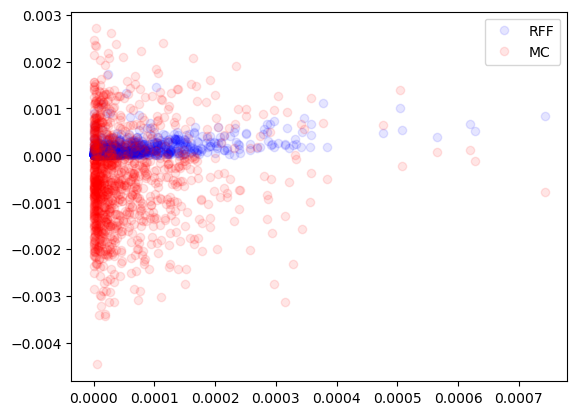

In [30]:
plt.plot(kappamap_225[pix_valid1000]**2, mmd2_rbf_rff1000, 'o', alpha=0.1, label='RFF', color='blue')
plt.plot(kappamap_225[pix_valid1000]**2, mmd2_rbf_MC1000, 'o', alpha=0.1, label='MC', color='red')
plt.legend()

### Finer Convergence map


In [16]:
# Create a smoother convergence map.
# From now on, we only use the big catalogue
nside_fine = 1024

kappamap_fine = hp.synfast( cl_kappa_225, nside_fine)
print(hp.nside2npix(nside_fine))

# Convert galaxy coordinates to pixel numbers in the finer map
gal_pix_fine = hp.ang2pix(nside_fine, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
gal_pix_fine_unique, gal_pix_fine_counts = np.unique(gal_pix_fine, return_counts=True)

# Compute observed sizes for all galaxies using the finer kappa map
observed_size_fine = intrinsic_size1000 * (1.0 + kappamap_fine[gal_pix_fine])


12582912


In [19]:
print("galaxy_pix1000 shape:", galaxy_pix1000.shape)
print("gal_pix_fine shape:", gal_pix_fine.shape)
print("kappamap_fine shape:", kappamap_fine.shape)

galaxy_pix1000 shape: (31574550,)
gal_pix_fine shape: (31574550,)
kappamap_fine shape: (12582912,)


In [ ]:
# Compute the MMDs for each bigger/coarser pixel but the new observed sizes.
# Compute also the averaged kappa values for each bigger pixel.

kappa_avg_fine = []

batch_size = 125
n_pixels = len(galaxy_pix1000_unique)
Y_lensed1000 = observed_size_fine[size_mask1000].reshape(-1, 1)

for i, batch_start in enumerate(range(0, n_pixels, batch_size)):    #Iterate over batches
    batch_end = min(batch_start + batch_size, n_pixels)
    pixel_batch = galaxy_pix1000_unique[batch_start:batch_end]
    mmd2_lensed_batch = []
    print(f"Starting with batch {i+1}.")
    for p in pixel_batch:  #Iterate over bigger pixels in the batch
        mask = (galaxy_pix1000 == p) 
        index = np.where(galaxy_pix1000_unique == p)[0][0]
        print(f"Pixel {index} of {n_pixels}")

        kappa_values = kappamap_fine[gal_pix_fine[mask]]    # Compute the mean kappa value for the bigger pixel
        kappa_avg = np.mean(kappa_values)
        kappa_avg_fine.append(kappa_avg)


        if mask.sum() > 20000:
            X_lensed_fine = observed_size_fine[mask & size_mask1000].reshape(-1, 1)
            mmd2 = compute_mmd_subsample(X_lensed_fine, Y_lensed1000, rbf_kernel, 20000,20000,3,42)
            mmd2_lensed_batch.append(mmd2)
        
    
    # Save batch results
    np.save(f'mmd2_lensed_rbf_fine_batch_{i+1}.npy', mmd2_lensed_batch)
    print(f"Batch {i+1} saved!")

np.save('kappa_avg_fine.npy', kappa_avg_fine)
print("kappa_avg_fine saved!")

In [ ]:
# Compute Noise Level for RBF kernel MMD via Subsampling for the new convergence map
mmd2_rbf_noise = []

rng = np.random.default_rng(42)

size = 20_000  # match your per-pixel (or subsample) size
for _ in range(1000):
    Xs = rng.choice(observed_size_fine[size_mask1000], size=size, replace=False)
    Ys = rng.choice(observed_size_fine[size_mask1000], size=size, replace=False)
    mmd2_rbf_noise.append(compute_mmd_subsample(Xs.reshape(-1,1), Ys.reshape(-1,1), rbf_kernel, size, size,3,42))

mmd2_rbf_noise = np.array(mmd2_rbf_noise)
np.save('mmd2_rbf_noise_fine.npy', mmd2_rbf_noise)
print("mmd2_rbf_noise_fine saved!")


In [24]:
# We forgot to compute the average kappa values for the bigger pixels of the recovery map!

# Create a finer kappa map for recovery
nside_fine = 1024
recovery_rand_seed = 31
np.random.seed(recovery_rand_seed)
recovery_kappamap = hp.synfast(cl_kappa_225, nside_fine)

kappa_recov_avg_fine = []

for p in galaxy_pix1000_unique:  #Iterate over bigger pixels
    mask = (galaxy_pix1000 == p) 
    kappa_values = recovery_kappamap[gal_pix_fine[mask]]    # Compute the mean kappa value for the bigger pixel
    kappa_avg = np.mean(kappa_values)
    kappa_recov_avg_fine.append(kappa_avg)

np.save('kappa_recov_avg_fine.npy', np.array(kappa_recov_avg_fine))
print("kappa_avg_fine saved!")


kappa_avg_fine saved!


In [26]:
kappa_recov_avg_fine = np.array(kappa_recov_avg_fine)